# Examen Práctico: Procesamiento de Imágenes

**Materia:** Procesamiento de Imágenes

**Parcial:** 3

**Nombre del Estudiante: Jesús Alberto Aréchiga Carrillo**

**Fecha: 08/dic/2025**

## Contexto: Control de Calidad Industrial

Imagina que trabajas para una empresa de manufactura de piezas metálicas. El sistema de visión artificial actual está fallando debido a la suciedad (grasa, óxido y polvo) en la cinta transportadora, lo que genera mucho "ruido" y variaciones de luz en las imágenes capturadas.

**Objetivo:**
Desarrolla un pipeline de procesamiento de imágenes en Python utilizando OpenCV que sea capaz de:

1.  **Preprocesar** la imagen para reducir el impacto de la grasa y el óxido.
2.  **Separar** (segmentar) las piezas metálicas (tuercas y engranajes) del fondo de manera robusta.
3.  **Limpiar** el ruido y perfeccionar la forma de los objetos detectados mediante morfología.
4.  **Contar** cuántas piezas aptas hay en la cinta.

Deberás justificar tus elecciones.


### 1. Configuración del Entorno y Carga de Imagen

Importa las librerías y carga la imagen asignada. Muestra la imagen original y en escala de grises lado a lado.

In [40]:
#Agrega tu código aquí.
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

img = cv2.imread('tuercas.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2_imshow(img)
cv2_imshow(img_gray)

Output hidden; open in https://colab.research.google.com to view.

### 2. Binarización y Segmentación (35 Puntos)

La imagen puede tener ruido y manchas que se confunden con las piezas. Tu objetivo es obtener una máscara binaria donde las piezas (tuercas, engranes, etc.) sean blancas y el fondo (la banda y todo lo demás) sea negro.

**Instrucciones:**

1.  Aplica un **suavizado** (ej. Box, Gauss) para reducir el ruido antes de la umbralización.
2.  Compara dos métodos de umbralización:
      * **Método A: Umbralización Fija.** Elige un valor manual (ej. 100) que creas conveniente.
      * **Método B: Umbralización de Otsu.** Deja que el algoritmo calcule el umbral óptimo.
3.  Muestra ambas imágenes binarias resultantes lado a lado.


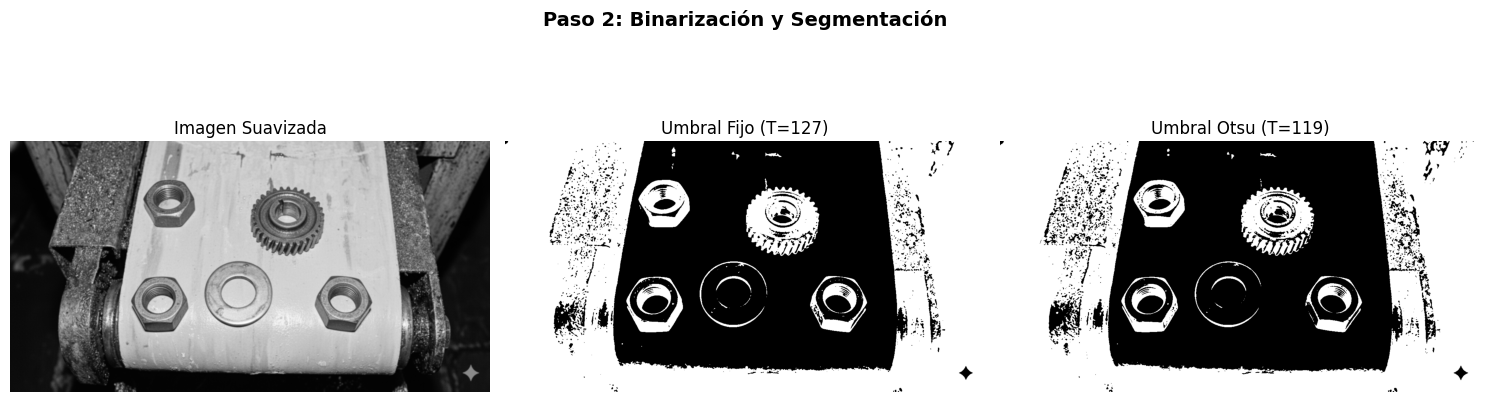

In [41]:
#Agrega tu código aquí.
img_suavizada = cv2.GaussianBlur(img_gray, (5, 5), 0)

valor_umbral_fijo = 127
_, mask_fija = cv2.threshold(img_suavizada, valor_umbral_fijo, 255, cv2.THRESH_BINARY_INV)
umbral_otsu, mask_otsu = cv2.threshold(img_suavizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Visualización lado a lado
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_suavizada, cmap='gray')
axes[0].set_title('Imagen Suavizada', fontsize=12)
axes[0].axis('off')

axes[1].imshow(mask_fija, cmap='gray')
axes[1].set_title(f'Umbral Fijo (T={valor_umbral_fijo})', fontsize=12)
axes[1].axis('off')

axes[2].imshow(mask_otsu, cmap='gray')
axes[2].set_title(f'Umbral Otsu (T={umbral_otsu:.0f})', fontsize=12)
axes[2].axis('off')

plt.suptitle('Paso 2: Binarización y Segmentación', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Pregunta Teórica:**
*Observa los resultados. ¿Cuál método funcionó mejor para separar las piezas del fondo? ¿Qué problema visual presenta el método que funcionó "peor"?*

> **Respuesta:** El umbral fijo con 127 funcionó mejor, la segmentación es más limpia.
Otsu presenta ruido excesivo en los bordes y Otsu está siendo más permisivo e incluye píxeles más oscuros como primer plano.



### 3. Limpieza Morfológica (35 Puntos)

La mejor imagen binaria del ejercicio anterior aún tendrá defectos como:

  * **Ruido:** Puntos blancos pequeños en el fondo o en las manchas.
  * **Huecos:** Agujeros negros dentro de las piezas blancas (que no son los agujeros reales de las tuercas).
  * **Conexiones:** Objetos que están muy juntos pueden aparecer unidos.

Debes usar operaciones morfológicas para limpiar la imagen.

**Instrucciones:**

1.  Define uno o más Kernels (estructuras de referencia).
2.  Diseña una secuencia de operaciones (Erosión, Dilatación, Apertura, Cierre) para:
      * Eliminar el ruido de fondo.
      * Asegurar que las piezas tengan una forma sólida.
3.  Muestra la imagen final limpia.


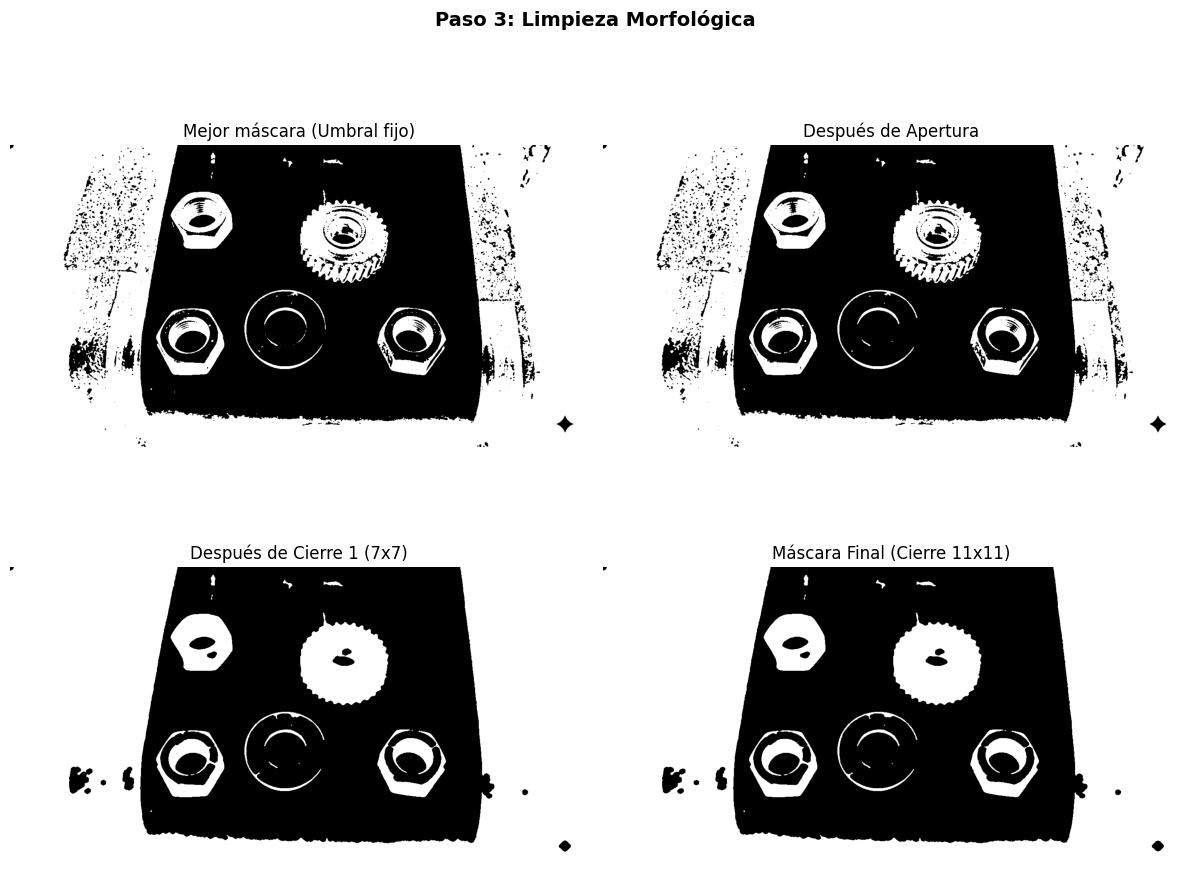

In [42]:
#Agrega tu código aquí.

mask_trabajo = mask_fija.copy()

kernel_pequeño = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel_mediano = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
kernel_grande = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

# Apertura suave para quitar ruido
mask_apertura = cv2.morphologyEx(mask_trabajo, cv2.MORPH_OPEN, kernel_pequeño, iterations=1)

# Cierre en dos etapas
mask_cierre1 = cv2.morphologyEx(mask_apertura, cv2.MORPH_CLOSE, kernel_mediano, iterations=2)
mask_final = cv2.morphologyEx(mask_cierre1, cv2.MORPH_CLOSE, kernel_grande, iterations=1)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(mask_trabajo, cmap='gray')
axes[0, 0].set_title('Mejor máscara (Umbral fijo)')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask_apertura, cmap='gray')
axes[0, 1].set_title('Después de Apertura')
axes[0, 1].axis('off')

axes[1, 0].imshow(mask_cierre1, cmap='gray')
axes[1, 0].set_title('Después de Cierre 1 (7x7)')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask_final, cmap='gray')
axes[1, 1].set_title('Máscara Final (Cierre 11x11)')
axes[1, 1].axis('off')

plt.suptitle('Paso 3: Limpieza Morfológica', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Pregunta Teórica:**
*Describe la secuencia de operaciones que usaste (ej. "Primero una Apertura para quitar ruido, luego un Cierre para rellenar huecos"). Justifica por qué elegiste ese orden.*

> **Respuesta:** Apertura primero, se empieza eliminando el ruido de fondo. Cierre segundo, una vez que el fondo está limpio, se aplica el cierre para rellenar los huecos internos de las piezas y suavizar sus contornos. Dilatación tercero y final, La apertura inicial erosiona ligeramente los bordes de las piezas. Esta dilatación ligera final recupera parte del tamaño perdido y asegura que las piezas tengan contornos bien definidos para el conteo posterior.



### 4. Conteo y Análisis de Piezas (30 Puntos)

Con la imagen limpia, el sistema debe contar las piezas detectadas.

**Instrucciones:**

1.  Utiliza `cv2.findContours` sobre la imagen obtenida en el ejercicio anterior.
2.  Filtra los contornos por área mínima para evitar contar restos de ruido como si fueran piezas. Tendrás que probar diferentes valores (ej. ignorar contornos con área menor a 500px) para elegir el que mejor resultdos de.
3.  Imprime el número final de piezas válidas detectadas.
4.  Visualización Final: Dibuja los contornos válidos y coloca etiquetas (en color verde o rojo) sobre la imagen original a color y muéstrala.

**El resultado esperado es el siguiente:**



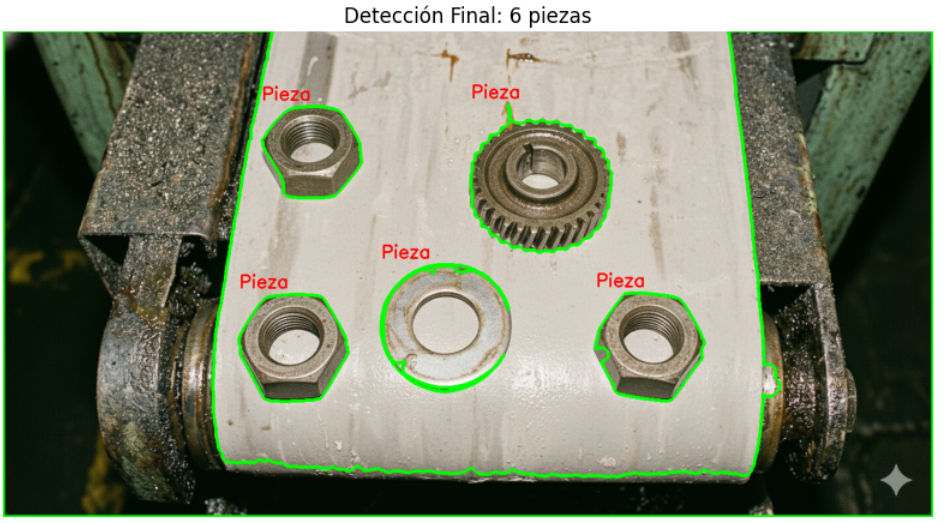

In [43]:
#Agrega tu código aquí.
contornos, _ = cv2.findContours(mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

AREA_MINIMA = 1000
AREA_MAXIMA = 50000

contornos_validos = []
for contorno in contornos:
    area = cv2.contourArea(contorno)
    if AREA_MINIMA <= area <= AREA_MAXIMA:
        contornos_validos.append(contorno)

# 3. Número final de piezas válidas
num_piezas = len(contornos_validos)

# 4. Visualización final sobre la imagen original a color
img_resultado = img.copy()

for i, contorno in enumerate(contornos_validos):
    # Dibujar contorno en verde
    cv2.drawContours(img_resultado, [contorno], -1, (0, 255, 0), 2)

    # Calcular el centro del contorno para colocar la etiqueta
    M = cv2.moments(contorno)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    # Colocar etiqueta "Pieza" en rojo
    cv2.putText(img_resultado, "Pieza", (cx - 30, cy - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# Agregar título en la parte superior
cv2.putText(img_resultado, f"Deteccion Final: {num_piezas} piezas",
            (img_resultado.shape[1]//2 - 150, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

# Mostrar resultado
cv2_imshow(img_resultado)

Output hidden; open in https://colab.research.google.com to view.

### Asegúrate de que el código funciona de principio a fin antes de entregar. **Entrega en PDF y el archivo .ipynb**.